# **YouTube Sentiment Analysis using BERT model**

In [ ]:
!pip install -q transformers google-api-python-client

In [ ]:
!pip install -q emoji

In [ ]:
from transformers import pipeline
from googleapiclient.discovery import build
import emoji

import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
API_KEY = ""

youtube = build('youtube', 'v3', developerKey=API_KEY)
URL = input("Enter the URL of the video: ")



Enter the URL of the video: https://www.youtube.com/watch?v=0FtcHjI5lmw


In [ ]:
video_id = URL[-11:]
print(video_id)

0FtcHjI5lmw


In [ ]:
video_response = youtube.videos().list(
    part='snippet',
    id=video_id
).execute()

In [ ]:
upload_channel_id = video_response['items'][0]['snippet']['channelId']


In [ ]:
comments = []
next_page_token = None
while len(comments) < 500:
  request = youtube.commentThreads().list(
    part="snippet",
    videoId=video_id,
    maxResults=100,
    pageToken=next_page_token
  )
  response = request.execute()
  for item in response['items']:
    comment = item['snippet']['topLevelComment']['snippet']
    public = item['snippet']['isPublic']
    comments.append([
        comment['authorDisplayName'],
        comment['textOriginal'],
        public
    ])
  while True:
    try:
      next_page_token = response['nextPageToken']
      break
    except KeyError:
      break

In [ ]:
df = pd.DataFrame(comments, columns=['author', 'comment', 'public'])
df.head()

,author,comment,public
0,@analyticswithadam,Updated Video with Replies https://youtu.be/A1...,True
1,@mohamedmowena353,Can u make a video in how to scrape the captio...,True
2,@BECEOOYaashuDave,What if i want to extract the replies as well?...,True
3,@yuxrazafar8532,I want to extract the comments from a playlist...,True
4,@user-qo3ko1ex2f,Very useful video. Thank you for sharing shari...,True


In [ ]:
df.shape

(504, 3)

In [ ]:
hyperlink_pattern = re.compile(
    r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

threshold_ratio = 0.65


for i, comment in enumerate(df['comment']):
    comment = comment.lower().strip()
    emojis = emoji.emoji_count(comment)
    text_characters = len(re.sub(r'\s', '', comment))
    if (any(char.isalnum() for char in comment)) and not hyperlink_pattern.search(comment):
        if emojis == 0 or (text_characters / (text_characters + emojis)) > threshold_ratio:
            df.loc[i, 'comment'] = comment

df.head()

,author,comment,public
0,@analyticswithadam,Updated Video with Replies https://youtu.be/A1...,True
1,@mohamedmowena353,can u make a video in how to scrape the captio...,True
2,@BECEOOYaashuDave,what if i want to extract the replies as well?...,True
3,@yuxrazafar8532,i want to extract the comments from a playlist...,True
4,@user-qo3ko1ex2f,very useful video. thank you for sharing shari...,True


In [ ]:
def sentiment_analysis(comment):
    sentiment = pipeline(model = "lxyuan/distilbert-base-multilingual-cased-sentiments-student",
                         return_all_scores = True)
    output = sentiment(comment)
    sentiment_result = max(output[0], key=lambda x: x['score'])
    label = sentiment_result['label']
    score = sentiment_result['score']
    return label, score

In [ ]:
sentiment_analysis("I love this movie and i would watch it again and again!")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


('positive', 0.9731044769287109)

In [ ]:
# Add 'sentiment' and 'score' columns to DataFrame
df['sentiment'] = ''
df['score'] = 0.0

# Loop through comments and assign sentiment analysis results to DataFrame
for i, comment in enumerate(df['comment']):
    label, score = sentiment_analysis(comment)
    df.loc[i, 'sentiment'] = label
    df.loc[i, 'score'] = score

# Display DataFrame
print(df.head())

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


               author                                            comment  \
0  @analyticswithadam  Updated Video with Replies https://youtu.be/A1...   
1   @mohamedmowena353  can u make a video in how to scrape the captio...   
2   @BECEOOYaashuDave  what if i want to extract the replies as well?...   
3     @yuxrazafar8532  i want to extract the comments from a playlist...   
4    @user-qo3ko1ex2f  very useful video. thank you for sharing shari...   

   public sentiment     score  
0    True  positive  0.513678  
1    True  positive  0.707319  
2    True  negative  0.456878  
3    True  negative  0.445031  
4    True  positive  0.925968  


In [ ]:
df.head()

,author,comment,public,sentiment,score
0,@analyticswithadam,Updated Video with Replies https://youtu.be/A1...,True,positive,0.513678
1,@mohamedmowena353,can u make a video in how to scrape the captio...,True,positive,0.707319
2,@BECEOOYaashuDave,what if i want to extract the replies as well?...,True,negative,0.456878
3,@yuxrazafar8532,i want to extract the comments from a playlist...,True,negative,0.445031
4,@user-qo3ko1ex2f,very useful video. thank you for sharing shari...,True,positive,0.925968


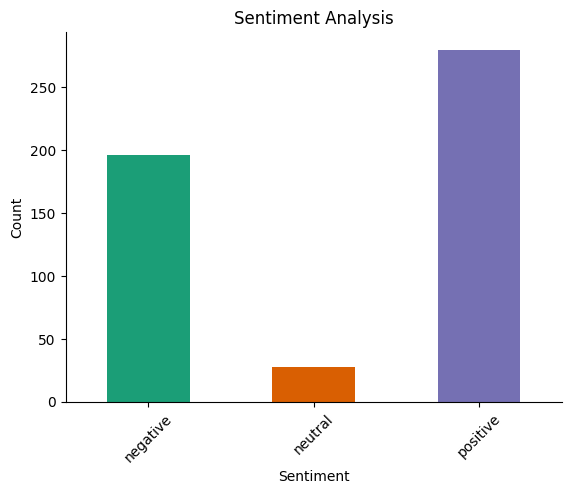

In [ ]:

df.groupby('sentiment').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xticks(rotation=45)
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Count')


plt.show()

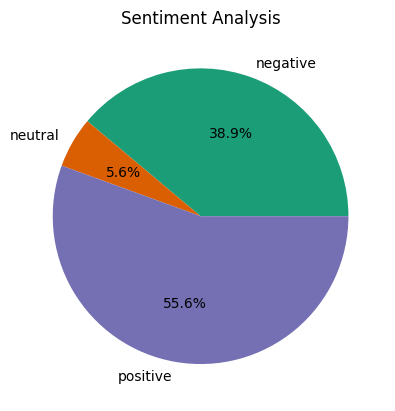

In [ ]:
sentiment_counts = df.groupby('sentiment').size()
sentiment_counts.plot(kind='pie', colors=sns.color_palette('Dark2'), startangle=0,  autopct='%1.1f%%')

plt.title('Sentiment Analysis')
plt.show()

In [ ]:
wait_extract_news = ExternalTaskSensor(
    task_id='wait_extract_news',
    external_dag_id='extract_dag',
    external_task_id=None,
    timeout=2000,
    dag=dag,
    mode='reschedule',
    allowed_states=["success"]
)

In [ ]:
wait_extract_comments = ExternalTaskSensor(
    task_id='wait_extract_comments',
    external_dag_id='extract_dag',
    external_task_id=None,
    timeout=2000,
    dag=dag,
    mode='reschedule',
    allowed_states=["success"])